###### Here a complete algorithm is developed to generate a concrete compressive strength prediction model using Gaussian processes with hyper parameter optimization via optuna. The algorithm selects the best kernel of a Gaussian process and obtains the optimal values of the hyperparameters through the optuna optimizer.

In [ ]:
import time
#from google.colab import drive
import numpy as np
import pandas as pd
import scipy.io 
from numpy import trapz
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
#importing Gaussian process library
from sklearn.gaussian_process import GaussianProcessRegressor
#Importing Gaussian Process Kernels
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, Matern,RationalQuadratic, DotProduct,WhiteKernel, ConstantKernel
from sklearn.metrics import mean_squared_error
from sklearn import svm
from matplotlib.pyplot import figure as fig
from sklearn.model_selection import train_test_split
import pickle

In [2]:
#installing and importing optuna optimizer
!pip install --quiet optuna 
import optuna
from optuna.samplers import TPESampler

You should consider upgrading via the 'C:\Users\crbw7\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


# Reading and extracting data

In [3]:
df = pd.read_excel("Concrete_Data.xls")

In [25]:
df1.columns

Index(['Cement (Kg)', 'blast furnace slag (Kg)', 'fly ash (Kg)', 'water',
       'superplasticizer (Kg)', 'coarse aggregate (Kg)', 'fine aggregate (Kg)',
       'age (days)', 'Compressive Strength (MPa)'],
      dtype='object')

## Checking the number of rows and number of columns

## Making a copy of the original data frame

In [4]:
df1 = df.copy()

In [5]:
df1.columns=['Cement (Kg)', 'blast furnace slag (Kg)', 'fly ash (Kg)', 'water', 'superplasticizer (Kg)',
             'coarse aggregate (Kg)', 'fine aggregate (Kg)',
             'age (days)', 'Compressive Strength (MPa)']

In [6]:
df1.head(5)
pd.set_option('colheader_justify', 'center')

In [7]:
df1.head(5)

,Cement (Kg),blast furnace slag (Kg),fly ash (Kg),water,superplasticizer (Kg),coarse aggregate (Kg),fine aggregate (Kg),age (days),Compressive Strength (MPa)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [8]:
ylabel =['Cement (kg in a m^3 of mixture)',
        'Blast furnace slag (kg in a m^3 of mixture)',
        'Fly ash (kg in a m^3 of mixture)',
        'Water (kg in a m^3 of mixture)',
        'Superplasticizer (kg in a m^3 of mixture)',
        'Coarse Aggregate (kg in one m^3 of mixture)',
        'Fine Aggregate (kg in a m^3 of mixture)', 'Time (days)',
        'Compressive Strength (MPa, megapascals)']

In [9]:
#For practicality, each of the parameters or predictor variables (or inputs), these will be
#denoted with C1 to C8 and the output variable denoted as R_C (compressive strength).
df.columns = ['C1','C2','C3','C4','C5','C6','C7', 'C8','R_C']

In [10]:
df.head(12)

,C1,C2,C3,C4,C5,C6,C7,C8,R_C
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.698299
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.289790


In [11]:
df.C1.values

array([540. , 540. , 332.5, ..., 148.5, 159.1, 260.9])

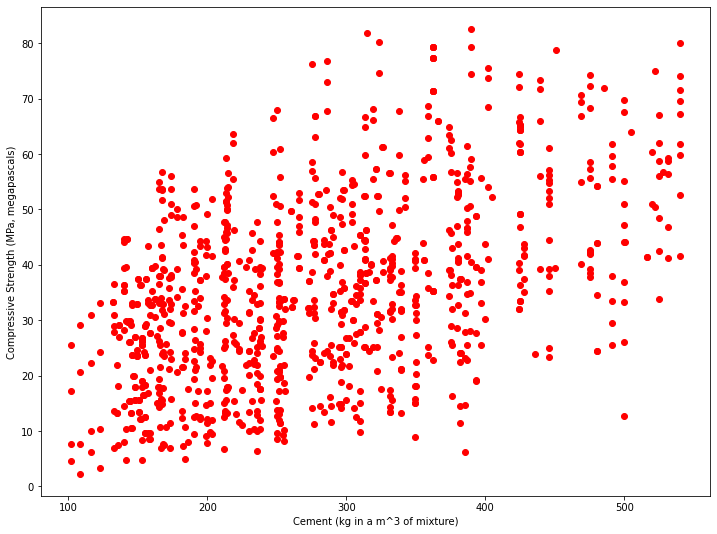

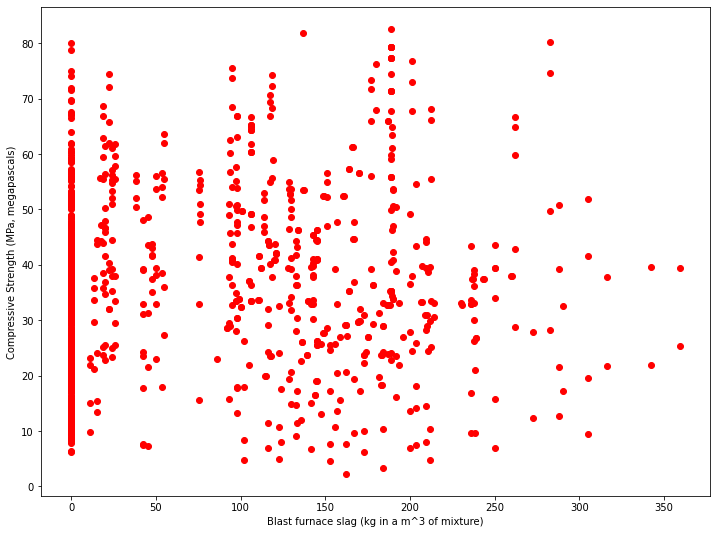

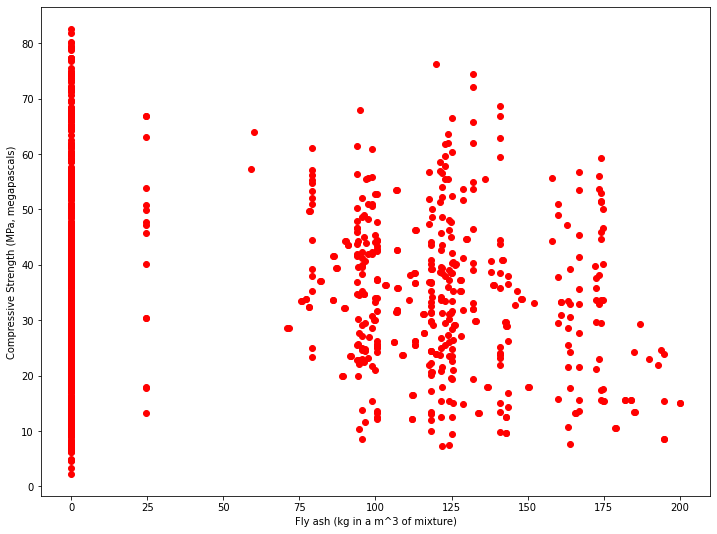

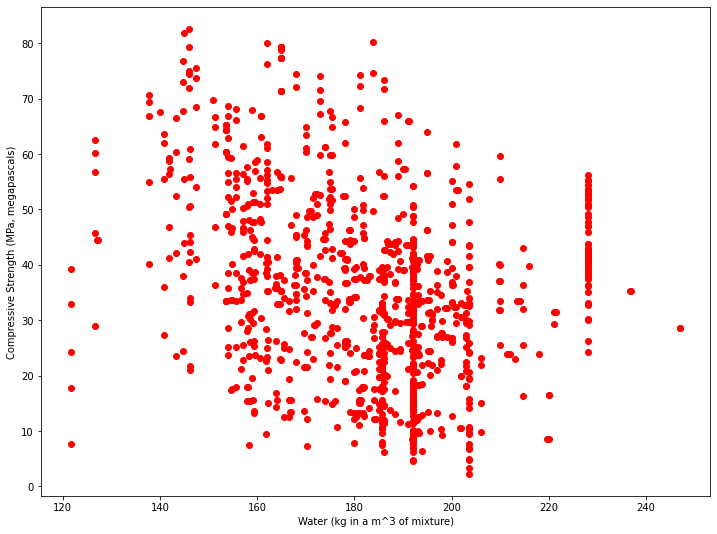

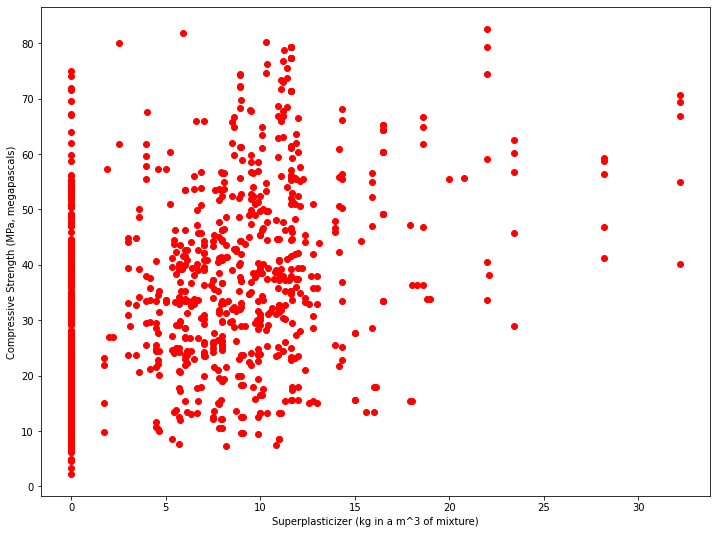

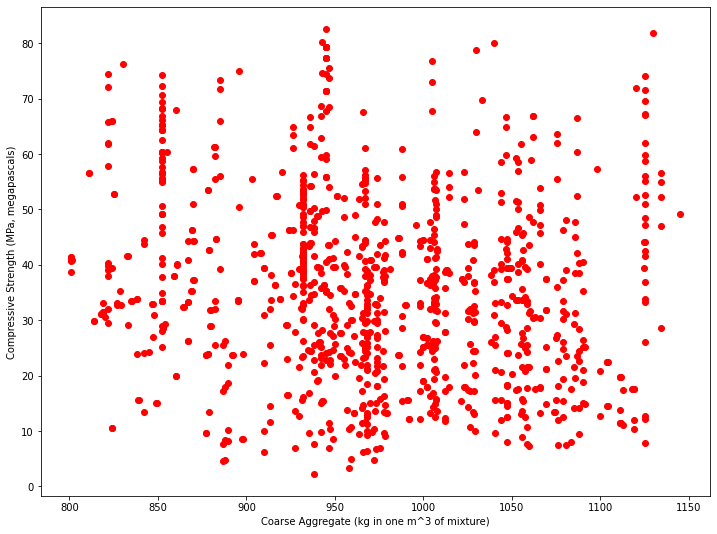

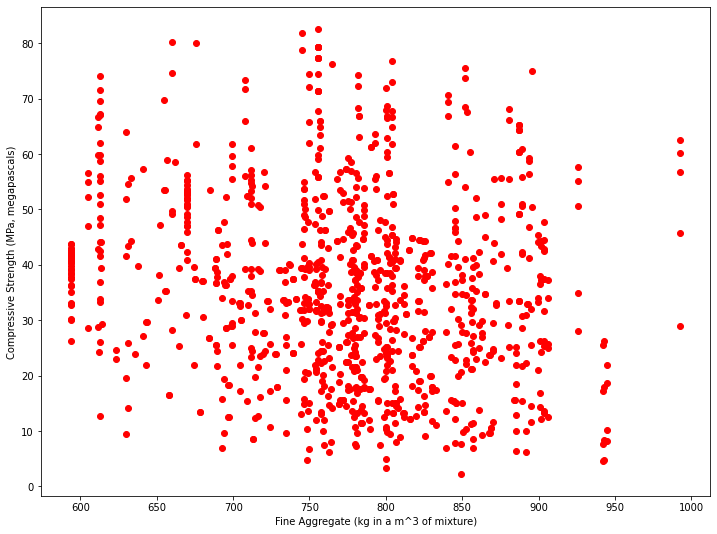

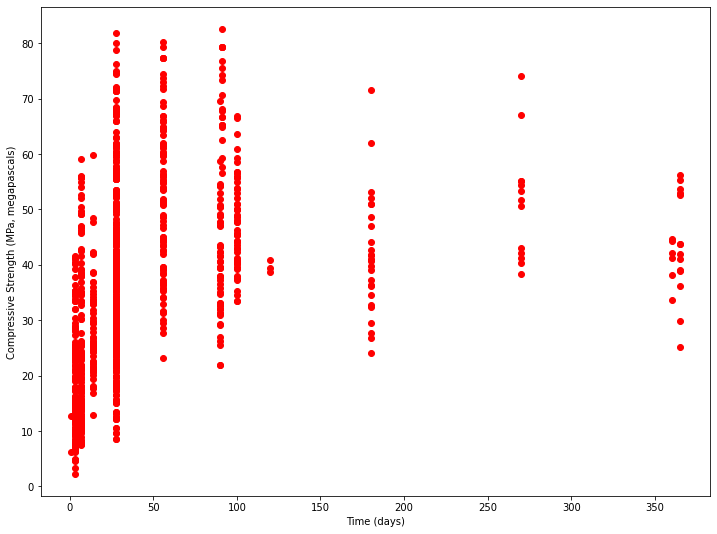

In [13]:
for i in range(len(df1.columns)-1):
    fig(num=None, figsize = (12,9))
    plt.plot(df1[df1.columns.values[i]].values,df1['Compressive Strength (MPa)'].values, "ro")
    plt.xlabel(ylabel[i])
    plt.ylabel(ylabel[8])

## Data partition

### Separating the features (or input data) from the target variable (or output variable)

In [37]:
X = df.drop(['R_C'], axis = 1)
y = df['R_C']

In [38]:
y.values

array([79.98611076, 61.88736576, 40.26953526, ..., 23.69660064,
       32.76803638, 32.40123514])

In [39]:
Test = 0.3

In [40]:
X_t, X_val, y_t, y_val = train_test_split(X, y, test_size = Test ,shuffle = False)

In [41]:
len(X_t)

721

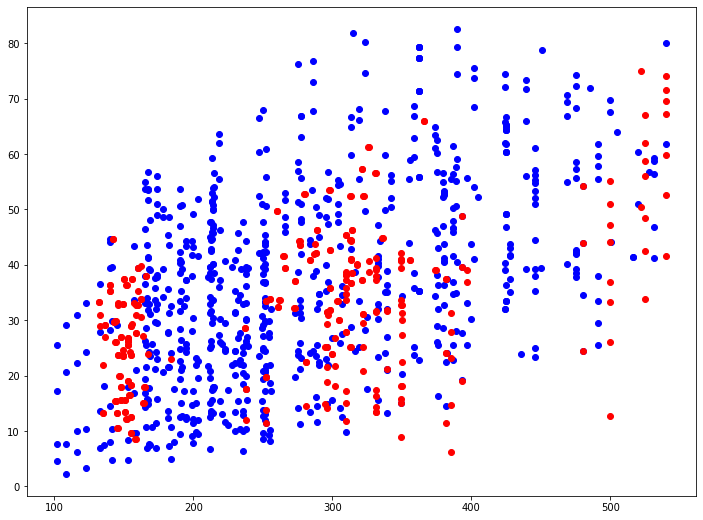

In [42]:
fig(num = None, figsize= (12,9))
plt.plot(X_t["C1"].values,y_t.values,"bo")
plt.plot(X_val["C1"].values,y_val.values,"ro")
plt.show()

In [43]:
c1_v = X_val["C1"].values[:,None]
c2_v = X_val["C2"].values[:,None]
c3_v = X_val["C3"].values[:,None]
c4_v = X_val["C4"].values[:,None]
c5_v = X_val["C5"].values[:,None]
c6_v = X_val["C6"].values[:,None]
c7_v = X_val["C7"].values[:,None]
c8_v = X_val["C8"].values[:,None]

y_v = y_val.values

In [44]:
c_val = np.concatenate((c1_v,c2_v,c3_v, c4_v, c5_v, c6_v, c7_v, c8_v), axis = 1)

In [45]:
#We do the division randomly, distributing 80% of the data frame as data to train.

X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size = 0.3,shuffle =True )

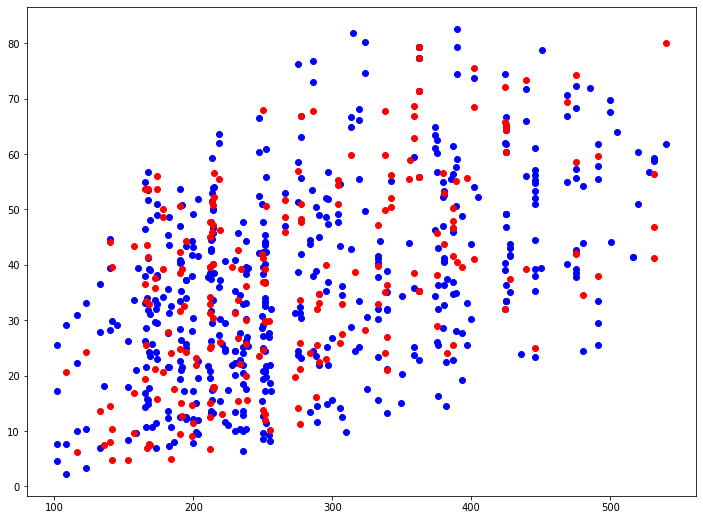

In [46]:
fig(num = None, figsize= (12,9))
plt.plot(X_train["C1"].values,y_train.values,"bo")
plt.plot(X_test["C1"].values,y_test.values,"ro")
plt.show()

In [47]:
c1_t = X_train["C1"].values[:,None]
c2_t = X_train["C2"].values[:,None]
c3_t = X_train["C3"].values[:,None]
c4_t = X_train["C4"].values[:,None]
c5_t = X_train["C5"].values[:,None]
c6_t = X_train["C6"].values[:,None]
c7_t = X_train["C7"].values[:,None]
c8_t = X_train["C8"].values[:,None]

y_tr = y_train.values

c1_test = X_test["C1"].values[:,None]
c2_test = X_test["C2"].values[:,None]
c3_test = X_test["C3"].values[:,None]
c4_test = X_test["C4"].values[:,None]
c5_test = X_test["C5"].values[:,None]
c6_test = X_test["C6"].values[:,None]
c7_test = X_test["C7"].values[:,None]
c8_test = X_test["C8"].values[:,None]

y_ts = y_test.values

In [48]:
c_train = np.concatenate((c1_t,c2_t,c3_t, c4_t, c5_t, c6_t, c7_t, c8_t), axis = 1) # to trining
c_test = np.concatenate((c1_test,c2_test,c3_test, c4_test, c5_test, c6_test, c7_test, c8_test), axis = 1)

## Kernels to Evaluate

In [49]:
#KERN = {0:[DotProduct()],
KERN = {0:[ConstantKernel()*Matern(length_scale=1.0,nu=1.5)],
        1:[ConstantKernel()*Matern(length_scale=1.0,nu=2.5)],
        2:[ConstantKernel()*RBF()],
        3:[ConstantKernel()*Matern(length_scale=1.0,nu=1.5) + ConstantKernel()*Matern(length_scale=1.0,nu=2.5)]}
        

In [50]:
# We generate lists for the kernel labels in the plots
KernName =['ConstantKernel*Matern32',
           'ConstantKernel*Matern52',
           'ConstantKernel*RBF',
           'ConstantKernel*Matern32+ConstantKernel*Matern52']


PlotName = ['ConstantKernelXMatern32',
           'ConstantKernelXMatern52',
           'ConstantKernelXRBF',
           'ConstantKernelXMatern32_ConstantKernelXMatern52']

In [51]:
KERN[0]

[1**2 * Matern(length_scale=1, nu=1.5)]

In [52]:
GP_KERN = []     # kernel 
GP_ALPHA = []    # Alpha parameter value
N_R_O = []       # n_restarts_optimizer value
R_S = []         # Rando state value
RMSE_train = []  # Rational mean squared error in data train
RMSE_test = []   # Rational mean squared error in data test
RMSE_val = []    # Rational mean squared error in data validation
NLML = []        # Negative log marginal likelihood value
SIGMA_t = {}     # Sigma parameter whit the train data value
SIGMA_v ={}      # Sigma parameter whit the validation data value
Modelo = {}      # Model obtinend 

In [53]:
Y_Pred_test = {}  #predictions with test data are stored here
Y_Pred_val = {}   #predictions with validation data are stored here

In [54]:
#alfa_med = 0.95/2
#Za_med = 1.645

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is 

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\c

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\c

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\c

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
C:\Users\c


Learned kernel: 6.1**2 * Matern(length_scale=522, nu=1.5)
Log-marginal-likelihood: -354.538


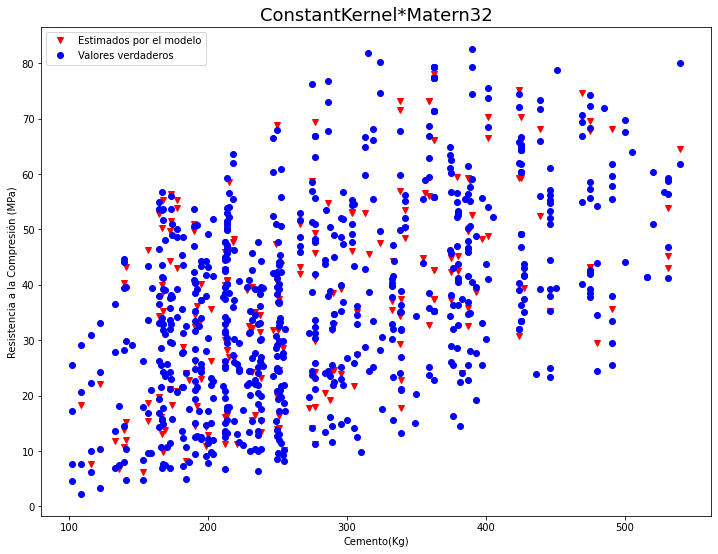

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
 

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\c

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\c

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\c

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=2.5) which is of type Product.
  warnings.warn(message)
C:\Users\c


Learned kernel: 5.53**2 * Matern(length_scale=328, nu=2.5)
Log-marginal-likelihood: -325.261


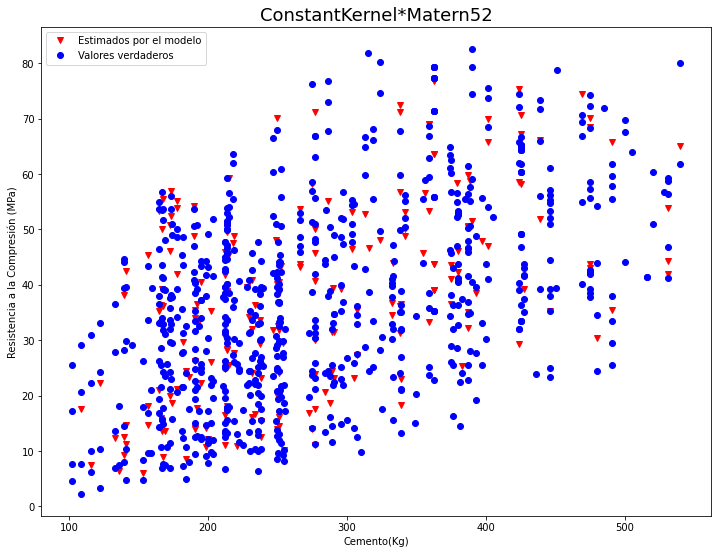

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\crbw7\AppData\Loca

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Pytho

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\cr

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Pytho

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Pytho


Learned kernel: 3.8**2 * RBF(length_scale=178)
Log-marginal-likelihood: -296.870


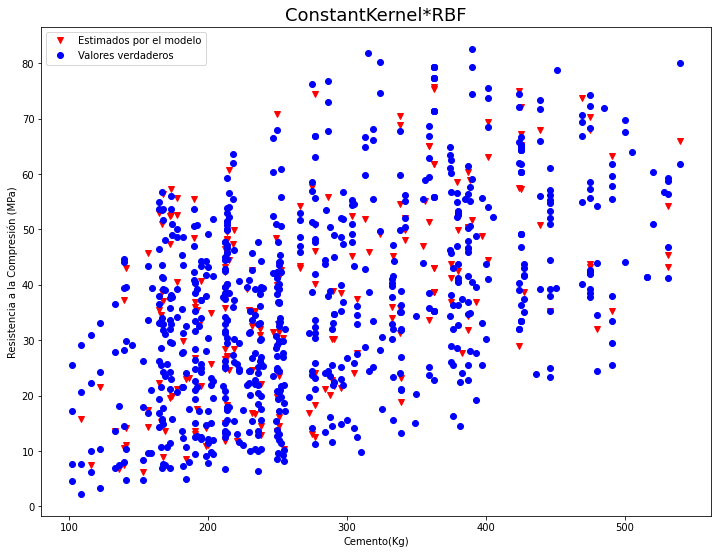

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(le

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the b

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=

C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * Matern(length_scale=1, nu=2.5) which is of type Sum.
  warnings.warn(message)
C:\Users\crbw7\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\distributions.py:427: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=


Learned kernel: 0.233**2 * Matern(length_scale=2.98e-05, nu=1.5) + 5.58**2 * Matern(length_scale=393, nu=2.5)
Log-marginal-likelihood: -398.597


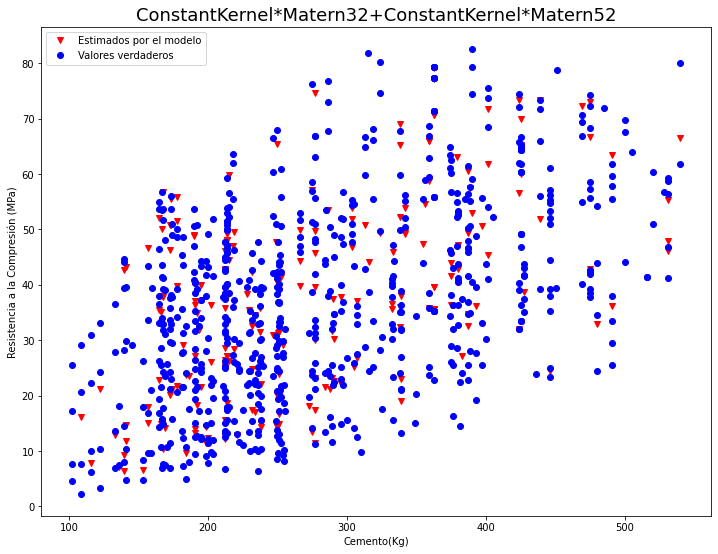

In [55]:
for i in range(len(KERN)):
  def objective(trial):
    
    kernels=KERN[i]
  
    params = {'kernel': trial.suggest_categorical('kernel', kernels), 
              'alpha': trial.suggest_loguniform('alpha',0.0000000001,1000),
              'n_restarts_optimizer': trial.suggest_int('n_restarts_optimizer',0,20),
              'normalize_y': trial.suggest_categorical('normalize_y', [True]),
              'random_state': trial.suggest_int('random_state',0,1000)}

    m_gp = GaussianProcessRegressor(**params)
    
    m_gp.fit(X_train, y_train)
    
    y_pred, sigma_val = m_gp.predict(X_test, return_std=True)

    rmse = mean_squared_error(y_ts,y_pred)**(1/2.0)

    return rmse

  optuna.logging.disable_default_handler()
  study = optuna.create_study(direction='minimize', sampler= TPESampler())
  study.optimize(objective, n_trials= 100)
  params_gp= study.best_trial.params
  gp_kernel = params_gp["kernel"]
  gp_alpha = params_gp["alpha"]
  n_r_o = params_gp["n_restarts_optimizer"]
  r_s = params_gp["random_state"]
  ## Guradando en una lista los parámetros optimizados por optuna
  GP_KERN.append(params_gp["kernel"])
  GP_ALPHA.append(params_gp["alpha"])
  N_R_O.append(params_gp["n_restarts_optimizer"])
  R_S.append(params_gp["random_state"])

  #Definición del proceso gaussiano
  m_gp = GaussianProcessRegressor(alpha = gp_alpha, kernel=gp_kernel , normalize_y= True , 
                                    n_restarts_optimizer = n_r_o, random_state =r_s )
  #Ajuste  
  m_gp.fit(X_train, y_train)
  #imprimiendo el kernel 
  print("\nLearned kernel: %s" % m_gp.kernel_)
  Modelo[i] = m_gp.kernel_
  #Imprimiendo el logaritmo de la probabilidad marginal
  print("Log-marginal-likelihood: %.3f"
        % m_gp.log_marginal_likelihood(m_gp.kernel_.theta))
  ## Guardando El logaritmo de la probabilidad marginal en la lista NLML
  NLML.append(m_gp.log_marginal_likelihood(m_gp.kernel_.theta))
  ## haciendo las predicciones 
  y_pred_train, sigma_val_train = m_gp.predict(X_train, return_std=True)
  y_pred_test, sigma_val_test = m_gp.predict(X_test, return_std=True)
  y_pred_val, sigma_val_val = m_gp.predict(X_val, return_std=True)

  rmse_train = mean_squared_error(y_tr,y_pred_train)**(1/2.0)
  rmse_test = mean_squared_error(y_ts,y_pred_test)**(1/2.0)
  rmse_val = mean_squared_error(y_v,y_pred_val)**(1/2.0)
  
  RMSE_train.append(rmse_train)
  RMSE_test.append(rmse_test)
  RMSE_val.append(rmse_val)
  #X_tes = np.array(np.float64(c_test.iloc[:,0]))[:, None]

  Y_Pred_test[i] = y_pred_test
  Y_Pred_val[i]=y_pred_val  
  SIGMA_t[i] = sigma_val_test
  SIGMA_v[i] = sigma_val_val
  
    ##Saving model

  pickle.dump(m_gp, open('model_'+ PlotName[i] + '.'+'pkl', 'wb'))
    
    ##plotted the results 
    
  fig(num = None, figsize = (12,9))
  
  plt.plot(c1_test,y_pred_test,"rv", label = "Estimados por el modelo")
  
  plt.plot(X_t["C1"].values,y_t.values, "bo",label = "Valores verdaderos")
  plt.xlabel("Cemento(Kg)")
  plt.ylabel("Resistencia a la Compresión (MPa)")
  plt.legend(loc="best")
  plt.title(KernName[i],fontsize = 18)
  #plt.ylim(0.5,1.1)
  plt.savefig('D:/Resultados/' + PlotName[i] + '.' + 'png')
  plt.show()
  
  
  
  


In [56]:
#Showing the kernel
m_gp.kernel_

0.233**2 * Matern(length_scale=2.98e-05, nu=1.5) + 5.58**2 * Matern(length_scale=393, nu=2.5)

In [57]:
#Showing the models
Modelo

{0: 6.1**2 * Matern(length_scale=522, nu=1.5),
 1: 5.53**2 * Matern(length_scale=328, nu=2.5),
 2: 3.8**2 * RBF(length_scale=178),
 3: 0.233**2 * Matern(length_scale=2.98e-05, nu=1.5) + 5.58**2 * Matern(length_scale=393, nu=2.5)}

In [58]:
#Saving sigma parametter in excel file
sigma_v = pd.DataFrame(SIGMA_v)
sigma_v.columns = PlotName
sigma_v.to_excel ('D:/Resultados/R4/Sigma_v_04.xlsx', index = False, header=True)

In [59]:
df_Y_Pred_test = pd.DataFrame(Y_Pred_test)
df_Y_Pred_val = pd.DataFrame(Y_Pred_val)
df_Y_Pred_test.columns=KernName
df_Y_Pred_val.columns = KernName


Resultados = pd.DataFrame({"Kernel":KernName,"NLML":NLML, "RMSE_test":RMSE_test,
                           "RMSE_val":RMSE_val,"Alpha":GP_ALPHA, 
                           "N_RStarts_Optimizers": N_R_O, "Random State":R_S})

# putting values in a Data Frame
Y_t = pd.DataFrame({"Resistencia a la compresión":y_t})
Y_val = pd.DataFrame({"Resistencia a la compresión":y_val})
Y_train = pd.DataFrame({"Resistencia a la compresión":y_train})
Y_test = pd.DataFrame({"Resistencia a la compresión":y_test})

#Saving in Excel exporting to folder R1

Y_t.to_excel ('D:/Resultados/R4/Y_t_04.xlsx', index = False, header=True)
Y_val.to_excel ('D:/Resultados/R4/Y_val_04.xlsx', index = False, header=True)
Y_train.to_excel ('D:/Resultados/R4/Y_train_04.xlsx', index = False, header=True)
Y_test.to_excel ('D:/Resultados/R4/Y_test_04.xlsx', index = False, header=True)

X_t.to_excel ('D:/Resultados/R4/X_t_04.xlsx', index = False, header=True)
X_val.to_excel ('D:/Resultados/R4/X_val_04.xlsx', index = False, header=True)
X_train.to_excel ('D:/Resultados/R4/X_train_04.xlsx', index = False, header=True)
X_test.to_excel ('D:/Resultados/R4/X_test_04.xlsx', index = False, header=True)

df_Y_Pred_test.to_excel ('D:/Resultados/R4/df_Y_Pred_test_04.xlsx', index = False, header=True)
df_Y_Pred_val.to_excel ('D:/Resultados/R4/df_Y_Pred_val_04.xlsx', index = False, header=True)

Resultados.to_excel ('D:/Resultados/R4/Result_04.xlsx', index = False, header=True)

In [62]:
#showing what was saved in the data frame "Resultados"
Resultados

,Kernel,NLML,RMSE_test,RMSE_val,Alpha,N_RStarts_Optimizers,Random State
0,ConstantKernel*Matern32,-354.537739,5.141856,10.345195,0.021366,12,665
1,ConstantKernel*Matern52,-325.260913,5.170207,11.972937,0.027560,12,163
2,ConstantKernel*RBF,-296.869598,5.283066,13.523290,0.039802,4,356
3,ConstantKernel*Matern32+ConstantKernel*Matern52,-398.596650,5.157859,11.991149,0.005347,19,423


In [63]:
Resultados4 = pd.DataFrame({"Kernel":KernName,"NLML":NLML, "RMSE_test":RMSE_test,
                           "RMSE_val":RMSE_val,"Alpha":GP_ALPHA, 
                           "N_RStarts_Optimizers": N_R_O, "Random State":R_S})

In [65]:
#saving resoults
Resultados4.to_excel ('D:/Notbooks/CruzB/CocreteData/Result_04.xlsx', index = False, header=True)

In [ ]:
Resultados = pd.DataFrame({"Kernel":KernName,"NLML":NLML, "RMSE_test":RMSE_test, "RMSE_val":RMSE_val,"Alpha":GP_ALPHA,
                           "N_RStarts_Optimizers": N_R_O, "Random State":R_S})